In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load f-score
fscore_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'fscore_2mn_clips.csv')
fscore_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'fscore_2mn_clips.csv')
# Order
desired_order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
fscore_lena['group_id'] = pd.Categorical(fscore_lena['group_id'], categories=desired_order, ordered=True)
fscore_vtc['group_id'] = pd.Categorical(fscore_vtc['group_id'], categories=desired_order, ordered=True)
fscore_lena = fscore_lena.sort_values('group_id')
fscore_vtc = fscore_vtc.sort_values('group_id')

print('Computing on %d chunks' % len(fscore_lena))
def compute_fscore(fscore_data):
    speakers = ['CHI', 'FEM', 'MAL', 'OCH']
    for speaker in speakers:
        # Precision = 1 if retrieved == 0 (all retrieved instances are correct since there was no retrieve instances
        fscore_data[f'precision_{speaker}'] = np.where(
            fscore_data[f'retrieved_{speaker}'] == 0,
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'retrieved_{speaker}']
        )
    
        # Recall = 1 if relevant is 0 (all actual instances have been found since there was no example)
        fscore_data[f'recall_{speaker}'] = np.where(
            (fscore_data[f'relevant_{speaker}'] == 0),
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'relevant_{speaker}']
        )
    
        # F-score calculation
        numerator = 2 * fscore_data[f'precision_{speaker}'] * fscore_data[f'recall_{speaker}']
        denominator = fscore_data[f'precision_{speaker}'] + fscore_data[f'recall_{speaker}']
        fscore_data[f'fscore_{speaker}'] = np.where(denominator != 0, numerator / denominator, 0)

    total_duration = (fscore_data['relevant_CHI'] + fscore_data['relevant_OCH'] + 
                 fscore_data['relevant_FEM'] + fscore_data['relevant_MAL'])

    total_global_duration = fscore_data[['relevant_CHI', 'relevant_OCH', 'relevant_FEM', 'relevant_MAL']].sum().sum()
    global_weights = {spk: fscore_data[f'relevant_{spk}'].sum() / total_global_duration for spk in speakers}
    print(f'Weights: {global_weights}')
    for metric in ['precision', 'recall', 'fscore']:
        fscore_data[f'weighted_{metric}'] = 100*sum(
                fscore_data[f'{metric}_{spk}'] * global_weights[spk] 
                for spk in speakers
            )
        fscore_data[metric] = 100 * fscore_data[[f'{metric}_{spk}' for spk in speakers]].mean(axis=1)
    return fscore_data

fscore_lena = compute_fscore(fscore_lena)
fscore_vtc = compute_fscore(fscore_vtc)


Computing on 750 chunks
Weights: {'CHI': 0.33640247011535235, 'FEM': 0.4095326945285813, 'MAL': 0.12025165816238573, 'OCH': 0.13381317719368058}
Weights: {'CHI': 0.33640247011535235, 'FEM': 0.4095326945285813, 'MAL': 0.12025165816238573, 'OCH': 0.13381317719368058}


In [5]:
fscore_lena

,recording_id,onset,offset,group_id,retrieved_CHI,relevant_CHI,relevant retrieved_CHI,fscore_CHI,retrieved_OCH,relevant_OCH,...,precision_MAL,recall_MAL,precision_OCH,recall_OCH,weighted_precision,precision,weighted_recall,recall,weighted_fscore,fscore
556,20190618_135122_024883.wav,6837000,6957000,low_risk,0.0,0.0,0.0,1.000000,2450.0,0.0,...,0.0,1.0,0.000000,1.000000,68.462051,46.257036,85.542122,91.174161,63.733513,43.370490
627,20180808_110630_024879.wav,6837000,6957000,low_risk,8210.0,7881.0,5808.0,0.721894,0.0,0.0,...,1.0,1.0,1.000000,1.000000,76.385352,84.278289,74.792369,83.437689,75.514100,83.811003
473,20180530_181655_022873.wav,16289000,16409000,low_risk,2290.0,1990.0,1123.0,0.524766,1980.0,0.0,...,1.0,1.0,0.000000,1.000000,66.492037,60.438640,77.243555,84.163309,64.905140,59.623367
125,20180809_181624_025481.wav,28611000,28731000,low_risk,600.0,1241.0,600.0,0.651820,0.0,4846.0,...,0.0,1.0,1.000000,0.000000,87.974834,75.000000,28.289588,37.087027,21.927374,16.295492
626,20180808_110630_024879.wav,6620000,6740000,low_risk,6250.0,16185.0,4057.0,0.361667,19940.0,0.0,...,1.0,1.0,0.000000,1.000000,61.708498,58.227116,52.876830,67.888352,46.806578,47.846950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,20220728_144904_024880_2.wav,14868000,14988000,autism_sibling,1810.0,3392.0,0.0,0.000000,12700.0,1505.0,...,0.0,1.0,0.074567,0.629236,32.370861,21.015915,45.624290,56.101537,29.721065,20.387460
181,20220720_091357_024879_1.wav,6837000,6957000,autism_sibling,4890.0,5728.0,3645.0,0.686570,0.0,0.0,...,1.0,1.0,1.000000,1.000000,50.481882,68.634969,87.766649,90.908694,48.502867,67.164249
178,20230321_124603_024879_1.wav,49860000,49980000,autism_sibling,0.0,0.0,0.0,1.000000,0.0,0.0,...,1.0,1.0,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
509,20230405_090552_045738_2.wav,14868000,14988000,autism_sibling,13020.0,0.0,0.0,0.000000,8850.0,0.0,...,1.0,1.0,0.000000,1.000000,12.025166,25.000000,100.000000,100.000000,12.025166,25.000000


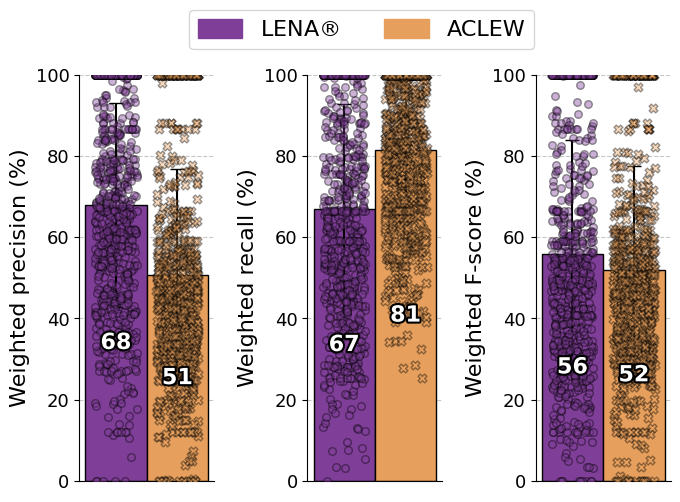

In [2]:
# SEGMENTATION SCORES
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.patheffects as path_effects

matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

cm = 1/2.54


lena_color = '#7F3E97'
aclew_color = '#E69F5C' 
def plot_corpus_metrics(fscore_lena, fscore_vtc, 
                       metrics = ['weighted_precision', 'weighted_recall', 'weighted_fscore'],
                       metric_name = ['Weighted precision (%)', 'Weighted recall (%)', 'Weighted F-score (%)']):
    metrics = ['weighted_precision', 'weighted_recall', 'weighted_fscore']
    fig_width = 6 * len(metrics)
    fig, axes = plt.subplots(1, len(metrics), figsize=(fig_width*cm, 12*cm))
    width = 0.35
    jitter_width = 0.12  # Reduced jitter width
    alpha = 1
    
    # Get means and stds for each metric at corpus level
    lena_means = [fscore_lena[f'{m}'].mean() for m in metrics]
    lena_stds = [fscore_lena[f'{m}'].std() for m in metrics]
    vtc_means = [fscore_vtc[f'{m}'].mean() for m in metrics]
    vtc_stds = [fscore_vtc[f'{m}'].std() for m in metrics]
    
    # Create each subplot
    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        # Plot bars with error bars
        ax.bar(-width/2, 
               lena_means[i], 
               width, 
               yerr=lena_stds[i],
               label='LENA', 
               color=lena_color, 
               edgecolor='black',
               alpha=alpha,
               zorder=2,
               error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
               
        ax.bar(width/2, 
               vtc_means[i], 
               width,
               yerr=vtc_stds[i],
               label='ACLEW', 
               color=aclew_color, 
               edgecolor='black',
               alpha=alpha,
               zorder=2,
               error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
        
        # Add scatter points with improved visibility
        # LENA scatter points
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(fscore_lena))
        ax.scatter([-width/2 + j for j in jitter], 
                  fscore_lena[metric],
                  color=lena_color,
                  edgecolor='black',
                  alpha=0.4,  # Added transparency
                  s=30,      # Reduced size
                  zorder=3)
        
        # ACLEW scatter points
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(fscore_vtc))
        ax.scatter([width/2 + j for j in jitter], 
                  fscore_vtc[metric],
                  color=aclew_color,
                  edgecolor='black',
                  alpha=0.4,  # Added transparency
                  s=40,      # Reduced size
                  marker='X', # Changed to smaller marker
                  zorder=3)
        
        ax.set_xticks([])
        ax.set_ylabel(metric_name[i])
        ax.set_ylim(0, 100)
        ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
        
        # Add value labels on top of bars
        for x, value in [(-width/2, lena_means[i]), (width/2, vtc_means[i])]:
            text = ax.text(x, value/2, f'{value:.0f}', 
                    ha='center', va='center', color='white', 
                    weight='bold', zorder=3, size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    handles = [plt.Rectangle((0,0),1,1, color=lena_color),  plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = [r'LENA$\circledR$', r'ACLEW']
    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.53, 1.03), loc='center')
    plt.tight_layout()
    return fig, axes

fig, axes = plot_corpus_metrics(fscore_lena, fscore_vtc, metrics = ['weighted_precision', 'weighted_recall', 'weighted_fscore'])
plt.savefig('/home/engaclew/neurogen/figures/2mn/segmentation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

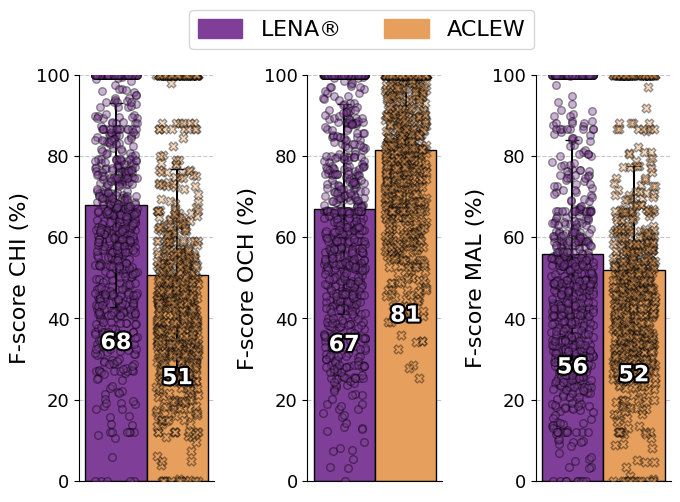

In [3]:
fig, axes = plot_corpus_metrics(fscore_lena, fscore_vtc, 
                                metrics = ['fscore_CHI', 'fscore_OCH', 'fscore_MAL', 'fscore_FEM'],
                                metric_name=['F-score CHI (%)', 'F-score OCH (%)', 'F-score MAL (%)', 'F-score FEM (%)'])


In [4]:
import pandas as pd

results_folder = Path('/home/engaclew/neurogen/results/agreement')
kappa_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'kappa_2mn_clips.csv')
kappa_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'kappa_2mn_clips.csv')
kappa_lena['kappa'] = (kappa_lena['kappa_CHI']+kappa_lena['kappa_OCH']+kappa_lena['kappa_MAL']+kappa_lena['kappa_FEM'])/4
kappa_vtc['kappa'] = (kappa_vtc['kappa_CHI']+kappa_vtc['kappa_OCH']+kappa_vtc['kappa_MAL']+kappa_vtc['kappa_FEM'])/4
print(len(kappa_vtc))

750


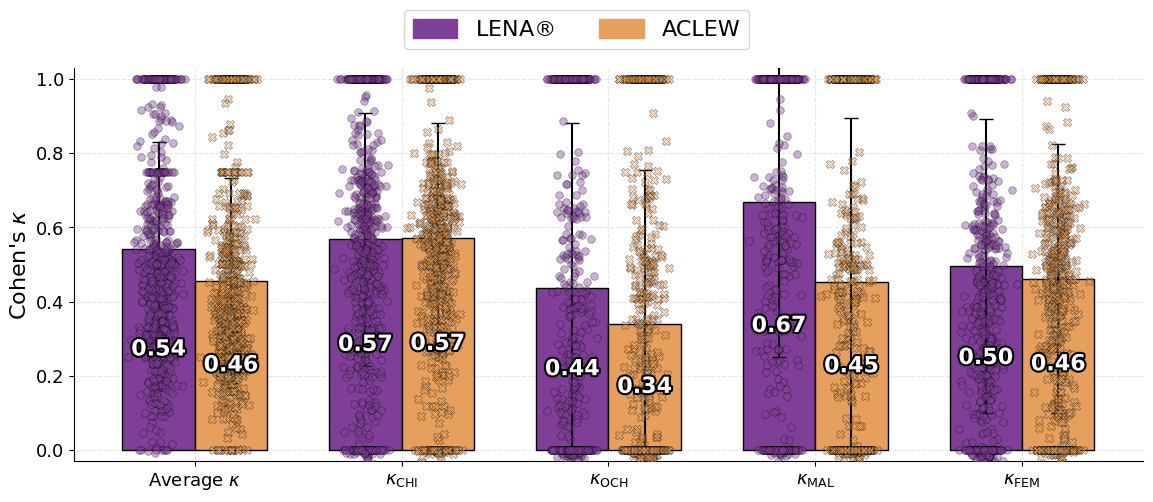

In [6]:
# Kappa
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

def plot_kappa_metrics(kappa_lena, kappa_vtc):
    import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.patheffects as path_effects
from scipy import stats

def plot_kappa_metrics(kappa_lena, kappa_vtc):
    cm = 1/2.54
    lena_color = '#7F3E97'
    aclew_color = '#E69F5C'
    alpha = 1
    
    metric_name = ['Average $\kappa$', r'$\kappa_{\text{CHI}}$', r'$\kappa_{\text{OCH}}$', 
                   r'$\kappa_{\text{MAL}}$', r'$\kappa_{\text{FEM}}$']
    metrics = ['kappa', 'kappa_CHI', 'kappa_OCH', 'kappa_MAL', 'kappa_FEM']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    lena_means = [kappa_lena[m].mean() for m in metrics]
    lena_stds = [kappa_lena[m].std() for m in metrics]
    vtc_means = [kappa_vtc[m].mean() for m in metrics]
    vtc_stds = [kappa_vtc[m].std() for m in metrics]
    
    fig_width = 6 * len(metrics)
    fig, ax = plt.subplots(1, 1, figsize=(fig_width*cm, 12*cm))
    
    error_props = dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1)
    
    # Plot bars
    ax.bar(x - width/2, lena_means, width, 
           yerr=lena_stds,
           label='LENA', 
           color=lena_color,
           edgecolor='black',
           alpha=alpha,
           zorder=2,
           error_kw=error_props)
           
    ax.bar(x + width/2, vtc_means, width,
           yerr=vtc_stds,
           label='ACLEW', 
           color=aclew_color,
           edgecolor='black',
           alpha=alpha,
           zorder=2,
           error_kw=error_props)
    
    # Add scatter points with improved visibility
    for i, metric in enumerate(metrics):
        lena_data = kappa_lena[metric]
        vtc_data = kappa_vtc[metric]
        
        jitter = width/8  # Reduced jitter
        x_jitter = np.random.normal(0, jitter, size=len(lena_data))
        
        # LENA scatter points
        ax.scatter(x[i]-width/2 + x_jitter, lena_data, 
                  color=lena_color,
                  edgecolor='black',
                  s=30,  # Reduced size
                  alpha=0.4,  # Added transparency
                  linewidth=0.5,  # Reduced edge width
                  zorder=3)
        
        # ACLEW scatter points
        ax.scatter(x[i]+width/2 + x_jitter, vtc_data, 
                  color=aclew_color,
                  edgecolor='black',
                  s=35,  # Reduced size
                  alpha=0.4,  # Added transparency
                  marker='X',  # Changed to smaller marker
                  linewidth=0.5,  # Reduced edge width
                  zorder=3)
    
    # Add value labels in middle of bars
    for i, (lena_mean, vtc_mean) in enumerate(zip(lena_means, vtc_means)):
        # LENA value
        text = ax.text(i - width/2, lena_mean/2, 
                f'{lena_mean:.2f}',
                ha='center',
                va='center',
                color='white',
                weight='bold',
                zorder=3,
                size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        # ACLEW value
        text = ax.text(i + width/2, vtc_mean/2,
                f'{vtc_mean:.2f}',
                ha='center',
                va='center',
                color='white',
                weight='bold',
                zorder=3,
                size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    ax.set_ylabel("Cohen's $\kappa$")
    ax.set_ylim(-0.03, 1.03)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_name)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    handles = [plt.Rectangle((0,0),1,1, color=lena_color), plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = [r'LENA$\circledR$', r'ACLEW']
    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.5, 1.03), loc='center', frameon=True)
    
    plt.tight_layout()
    return fig, ax


plot_kappa_metrics(kappa_lena, kappa_vtc)
plt.savefig('/home/engaclew/neurogen/figures/2mn/lena_vtc_kappa.png', dpi=300)
plt.show()


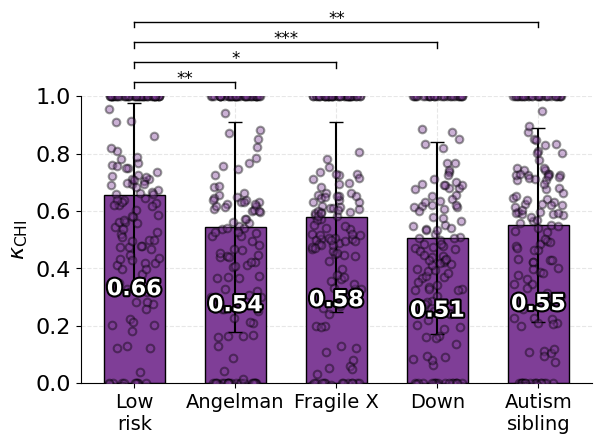

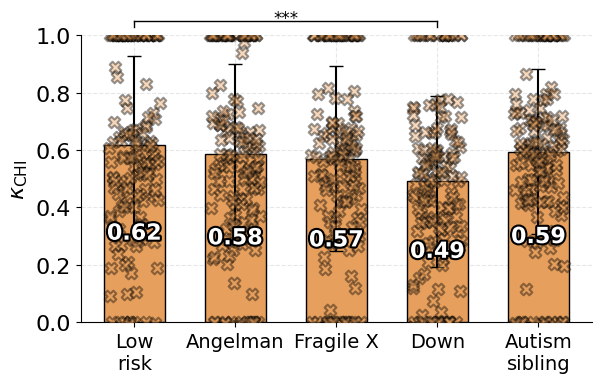

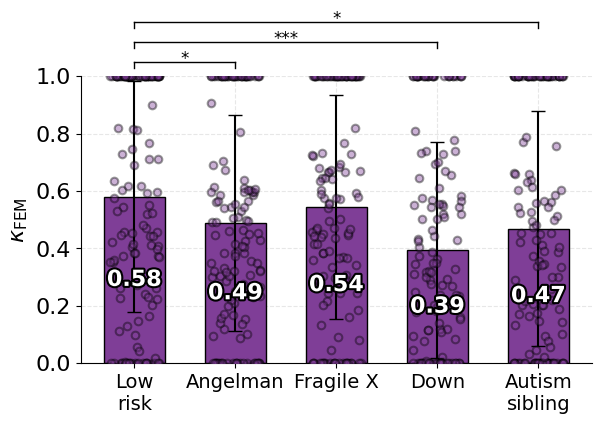

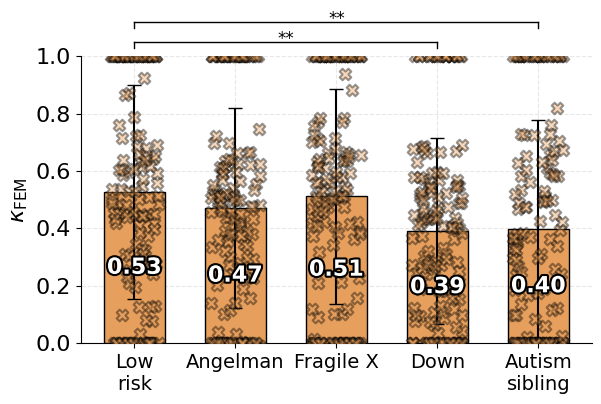

In [10]:
matplotlib.rcParams.update({
        'font.size': 16, 
        'legend.handleheight': 1,
        'hatch.linewidth': 1.0,
        'lines.markersize': 10, 
        'lines.linewidth': 2,
        'errorbar.capsize': 5,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16
    })

def add_group_significance_bars(ax, df, groups, col):
    def get_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        return ''
    
    # Get y-axis range
    ymin, ymax = ax.get_ylim()
    ydist = ymax - ymin
    
    # Calculate relative spacings
    stars_spacing = 0.01 * ydist  # Space between bar and stars
    bar_spacing = 0.07 * ydist    # Space between multiple bars
    tick_height = 0.02 * ydist    # Length of vertical ticks
    base_height = ymax + (0.05 * ydist)  # Starting height above plot
    
    # Perform statistical tests against low_risk group
    control_group = 'low_risk'
    control_data = df[df['group_id'] == control_group][col]
    
    # Calculate spacing in axes coordinates
    trans = ax.transAxes.inverted()
    x_positions = range(len(groups))
    
    sig_count = 0
    
    for i, group in enumerate(groups[1:], 1):
        if group in df['group_id'].unique():
            test_data = df[df['group_id'] == group][col]
            
            # Perform Mann-Whitney U test
            statistic, p_value = stats.mannwhitneyu(
                control_data, 
                test_data,
                alternative='two-sided'
            )
            
            # Only add bars for significant results
            stars = get_stars(p_value)
            if stars:
                current_height = base_height + (sig_count * bar_spacing)
                sig_count += 1
                
                # Draw the bar
                ax.plot(
                    [0, i],
                    [current_height, current_height],
                    'k-',
                    linewidth=1,
                    transform=ax.transData,
                    clip_on=False
                )
                
                # Add vertical ticks
                ax.plot(
                    [0, 0],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                ax.plot(
                    [i, i],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                
                # Add stars
                ax.text(
                    (0 + i) / 2,
                    current_height + stars_spacing,  # Using relative spacing
                    stars,
                    ha='center',
                    va='center',
                    fontsize=12,
                    clip_on=False
                )
    
    # Maintain original y-axis limits
    ax.set_ylim(ymin, ymax)
    ax.set_clip_on(False)
    
def plot_kappa_by_group(df, color, marker, cat='CHI'):
    if cat not in ['CHI', 'FEM', 'MAL', 'OCH']:
        raise ValueError("cat must be either 'CHI' or 'FEM'")
        
    kappa_col = f'kappa_{cat}'
    
    jitter_width = 0.25
    alpha = 1
    size = 30
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[kappa_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[kappa_col].std().reindex(groups, fill_value=0)
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 alpha=alpha,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][kappa_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      alpha=.4,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.2f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(r'$\kappa_{\text{' + cat + '}}$')
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    add_group_significance_bars(ax, df, groups, kappa_col)
    
    return fig, ax

plot_kappa_by_group(kappa_lena, color=lena_color, marker='o', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/lena_kappa_CHI.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_vtc, color=aclew_color, marker='X', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/vtc_kappa_CHI.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_lena, color=lena_color, marker='o', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/lena_kappa_FEM.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_vtc, color=aclew_color, marker='X', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/vtc_kappa_FEM.png', dpi=300)
plt.show()

/tmp/ipykernel_85589/241932622.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_85589/241932622.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


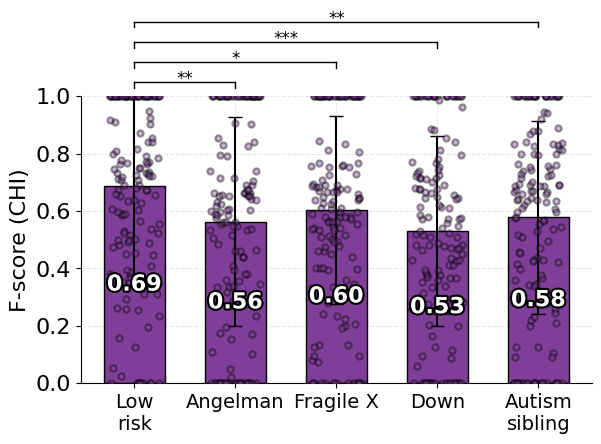

/tmp/ipykernel_85589/241932622.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_85589/241932622.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


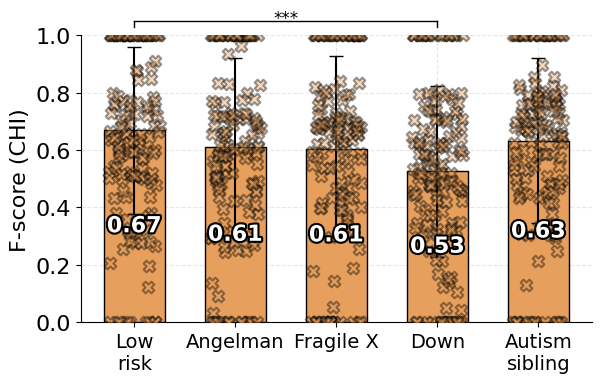

/tmp/ipykernel_85589/241932622.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_85589/241932622.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


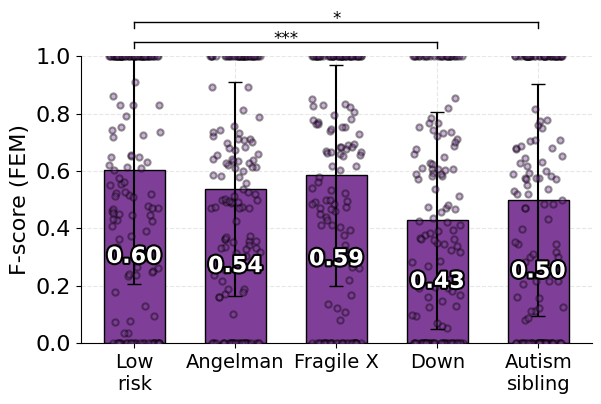

/tmp/ipykernel_85589/241932622.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_85589/241932622.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


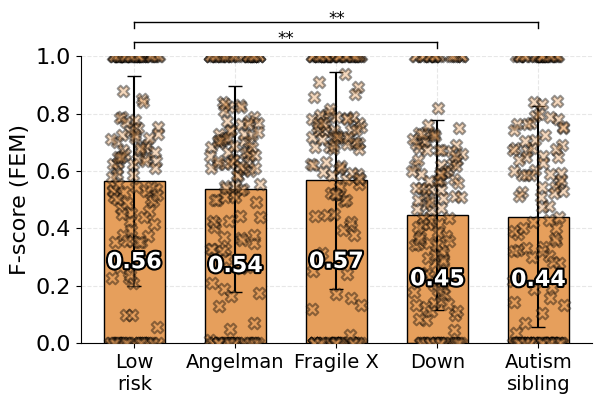

In [11]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects


def plot_fscore_by_group(df, color, marker, cat='CHI'):
    if cat not in ['CHI', 'FEM', 'MAL', 'OCH']:
        raise ValueError("cat must be either 'CHI' or 'FEM'")
        
    fscore_col = f'fscore_{cat}'
    
    jitter_width = 0.25
    alpha = .4
    size = 20
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][fscore_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      alpha=alpha,
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.2f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(f'F-score ({cat})')  # Changed from kappa to F-score
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    add_group_significance_bars(ax, df, groups, fscore_col)
    
    return fig, ax

plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/lena_fscore_FEM.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/vtc_fscore_CHI.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/lena_fscore_FEM.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/vtc_fscore_FEM.png', dpi=300)
plt.show()